# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd

import re, nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import  matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

Загрузим и прочитаем файл:

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

Выведим на экран первые строки датасета:

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Посмотрим общую информацию:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


У нас два столбца с объектным и целочисленным типам данных. Пропусков нет. 

Посмотрим на соотношения "позитивных" и "негативных" комментариев:

In [5]:
data['toxic'].value_counts(normalize=True).round(3)

0    0.898
1    0.102
Name: toxic, dtype: float64

10% комментариев токсичные и 90% нет. Классы несбалансированы - учтем это при разбиение датасета на выборки и используем параметр *stratify=y*. 

Приступим к подготовке данных.

Очистим и лемматизируем текст:

In [6]:
lemmatizer = WordNetLemmatizer()

def lemmatize_clear(text):
    text = text.lower() # перевод строк в нижний регистр
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text) # очистка текста 
    split_text = " ".join(clear_text.split())
    lemm_text = "".join(lemmatizer.lemmatize(split_text)) # лемматизация текста
        
    return lemm_text

data['lemm_text'] = data['text'].apply(lemmatize_clear) 

Выведим на экран полученную таблицу:

In [7]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Получили таблицу с комментариями до и после лемматезации + колонка с классификацией комментариев. 

# Вывод

Мы произвели чтение и загрузку данных. Подготовили данные для обучения: лемматизировали и очистили комментарии, добавили столбец обработанного текста в таблицу. 

Можем приступать к обучению.

## Обучение

### Подготовка к обучению

Подготовим данные для обучения. Разобьем датасет на три выборки: трейн, валид и  тест. Сначала обучим модель на трейне и сделаем предсказание на валиде. Выбрав лучшую модель, проверим качество предсказаний на тесте. 

В исследовании будем использовать 3 алгоритма:

1. LogisticRegression()
2. SGDClassifier()
3. CatBoostClassifier()

И сравним, какая из моделей покажет более высокое качество предсказаний. 

Выделим признак и целевой признак:

In [8]:
X = data['lemm_text']
y = data['toxic']

Разобьем датасет на обучающую, валидационную и тестовую выборку:

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.4, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

Создадим матрицу cо значениями TF-IDF по корпусу текстов, указав стоп-слова:

In [10]:
stop_words = set(nltk_stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stop_words)

Чтобы тестирование было честным и модель не учитывала частоты слов из валидационной/тестовой выборки, функцию *fit()* запустим только на обучающей выборке: 

In [11]:
tf_idf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

Теперь конвертируем все выборки:

In [12]:
X_train = tf_idf.transform(X_train)
X_valid = tf_idf.transform(X_valid)
X_test = tf_idf.transform(X_test)
print('Размер обучающей выборки: ', X_train.shape)
print('Размер валидационой выборки: ', X_valid.shape)
print('Размер тестовой выборки: ', X_test.shape)

Размер обучающей выборки:  (95742, 125014)
Размер валидационой выборки:  (31914, 125014)
Размер тестовой выборки:  (31915, 125014)


Все в порядке, приступаем к обучению.

### Обучение моделей

#### LogisticRegression()

Обучим модель Логистической регрессии и вычислим полноту, точность и f1-меру:

In [13]:
%%time 

model_LR = LogisticRegression(C=15, tol=0.0001).fit(X_train, y_train)
preds_LR = model_LR.predict(X_valid)
recall_LR = recall_score(y_valid, preds_LR)
precision_LR = precision_score(y_valid, preds_LR)
f1_LR = f1_score(y_valid, preds_LR)
print('Полнота: ', recall_LR)
print('Точность: ', precision_LR)
print('F1_score: ', f1_LR, '\n')

Полнота:  0.6898177247014456
Точность:  0.8832997987927566
F1_score:  0.7746603140991707 

CPU times: user 9.18 s, sys: 6.99 s, total: 16.2 s
Wall time: 16.2 s


F1-мера составила 0.77, что несколько больше требуемого значения 0.75. Модель с достаточно высоким уровнем точности выявляет нетоксичные комментарии, но значительно менее точно определяет токсичные, что и занижает качество предсказаний.

Посмотрим на матрицу ошибок:

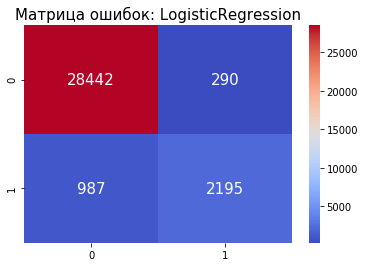

In [14]:
sns.heatmap(confusion_matrix(y_valid, preds_LR), fmt='3.0f', annot=True, cmap='coolwarm', annot_kws={"size":15})
plt.title('Матрица ошибок: LogisticRegression', size=15)
plt.show()

Среди ошибок чаще отмечаем ложнопозитивные оценки: 987 токсичных комментариев неверно определены, как нетоксичные. 

#### SGDClassifier()

Oбучим модель Стохастического градиентного спуска и вычислим полноту, точность и f1-меру:

In [15]:
model_SGD = SGDClassifier(alpha=1e-05, penalty='l1', random_state=12345).fit(X_train, y_train)
preds_SGD = model_SGD.predict(X_valid)
recall_SGD = recall_score(y_valid, preds_SGD)
precision_SGD = precision_score(y_valid, preds_SGD)
f1_SGD = f1_score(y_valid, preds_SGD)
print('Полнота: ', recall_SGD)
print('Точность: ', precision_SGD)
print('F1_score: ', f1_SGD)

Полнота:  0.6945317410433689
Точность:  0.8940129449838188
F1_score:  0.7817474354439335


Также, как и Логистическая регрессия, данный алгоритм чаще ошибается, присваивая статус "позитивный" токсичным комментариям.  

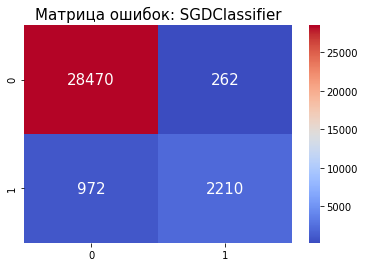

In [16]:
sns.heatmap(confusion_matrix(y_valid, preds_SGD), fmt='3.0f', annot=True, cmap='coolwarm', annot_kws={"size":15})
plt.title('Матрица ошибок: SGDClassifier', size=15)
plt.show()

В сравнении с Логистической регрессий, метод SGDClassifier несколько более точен при идентификации токсичных комментариев.  

#### CatBoostClassifier()

Посмотрим на результат CatBoost:

In [17]:
%%time

model_Cat = CatBoostClassifier(verbose=False, loss_function='Logloss', learning_rate=0.9, iterations=200, depth=4, random_state=12345).fit(X_train, y_train)
preds_Cat = model_Cat.predict(X_valid)
recall_Cat = recall_score(y_valid, preds_Cat)
precision_Cat = precision_score(y_valid, preds_Cat)
f1_Cat = f1_score(y_valid, preds_Cat)
print('Полнота: ', recall_Cat)
print('Точность: ', precision_Cat)
print('F1_score: ', f1_Cat, '\n')

Полнота:  0.6744186046511628
Точность:  0.8646253021756648
F1_score:  0.7577683615819208 

CPU times: user 8min 12s, sys: 19.2 s, total: 8min 32s
Wall time: 8min 35s


Результат в целом соответствует требованию - f1=0.76, но это ниже, чем у других алгоримов.

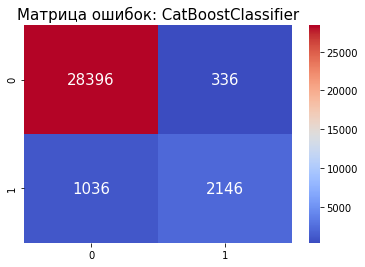

In [18]:
sns.heatmap(confusion_matrix(y_valid, preds_Cat), fmt='3.0f', annot=True, cmap='coolwarm', annot_kws={"size":15})
plt.title('Матрица ошибок: CatBoostClassifier', size=15)
plt.show()

Чуть большье ошибочных предсказаний 1-го и 2-го рода.

Объединим результат в одну таблицу:

In [19]:
score_table = pd.DataFrame(data=[[f1_LR, recall_LR, precision_LR], 
                                 [f1_SGD, recall_SGD, precision_SGD], 
                                 [f1_Cat, recall_Cat, precision_Cat]],
                       columns = ['F1_score', 'Recall', 'Precision'], 
                       index = ['LogisticRegression', 'SGDClassifier', 'CatBosstClassifier']).sort_values(by='F1_score', ascending=False)
score_table

,F1_score,Recall,Precision
SGDClassifier,0.781747,0.694532,0.894013
LogisticRegression,0.774660,0.689818,0.883300
CatBosstClassifier,0.757768,0.674419,0.864625


Модели демонстрируют близкие по значению результаты, но лучшей оказался Стохастический градиентный спуск. Именно эту модель используем для тестирования.

### Тестирование модели

Проверим модель SGDClassifier с установленными гиперпараметрами на тестовой выборке:

In [20]:
%%time 

model_test_SGD = SGDClassifier(alpha=1e-05, penalty='l1', random_state=12345).fit(X_train, y_train)
preds_test_SGD = model_test_SGD.predict(X_test)
recall_test_SGD = recall_score(y_test, preds_test_SGD)
precision_test_SGD = precision_score(y_test, preds_test_SGD)
f1_test_SGD = f1_score(y_test, preds_test_SGD)
print('Полнота: ', recall_test_SGD)
print('Точность: ', precision_test_SGD)
print('F1_score: ', f1_test_SGD, '\n')

Полнота:  0.682285368802902
Точность:  0.8875344081793157
F1_score:  0.7714920526405743 

CPU times: user 743 ms, sys: 81.7 ms, total: 824 ms
Wall time: 826 ms


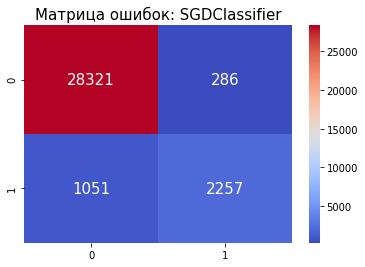

In [21]:
sns.heatmap(confusion_matrix(y_test, preds_test_SGD), fmt='3.0f', annot=True, cmap='coolwarm', annot_kws={"size":15})
plt.title('Матрица ошибок: SGDClassifier', size=15)
plt.show()

Качество предсказаний на тестовой выборке почти такое же, как и на валидационной. Несколько больше ошибок при ложноположительных и ложноотрицательных ответах. Тем не менее, показатель метрики соответствует условию проекта - f1 не ниже 0.75 

# Вывод

Мы подготовили данные для обучения и использовали несколько алгоритмов: Логистическая регрессия, метод Стохастического градиентного спуска и CatBoost. Качество предсказаний всех моделей оказалось очень близко. Тем не менее, лучше всего себя показала модель SGDClassifier, с набольшей точностью определившая число токсичных комментариев. 

## Выводы

В рамках данного проекта:

1. Данные были загружены, прочитаны и обработаны (лемматизация и очистка текста);
2. Для обучения произведена векторизация текста (создана матрицу TF-IDF со стоп-словами);
3. Проверены несколько моделей обучения с целью получить значение f1-меры не менее 0.75

В результате с помощью SGDClassifier удалось достичь значения метрики качества *F1* = 0.78 на валидацинной выборке и 0.77 на тестовой. Матрица ошибок показала, что модель достаточно точно определяет позитивные комментарии, но чаще ошибается при идентификации токсичных. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны